In [1]:
%matplotlib inline
import torch
from torch import optim,nn
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
import torchvision
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import re
import glob
from PIL import Image
import time

import copy
plt.ion()

In [2]:
# # Dataset creation
# all_image_path = []
# image_id = []
# for i in range(1,125):
#     if i<10:
#         app = "00"+str(i)
#     elif i<100:
#         app = "0"+str(i)
#     else :
#         app = str(i)
#     path = "/DATA/nirbhay/tharun/gei/"+app+"/"
#     files = glob.glob(path+"*.png")
#     if len(files)>=5:
#         for f in files:
#             all_image_path.append(f)
#             image_id.append(i)
# #to csv
# mappings = {'path':all_image_path,
#             'label':image_id
#            }
# df = pd.DataFrame(mappings,columns=['path','label'])
# df.to_csv('casiab_dataset_1_4.csv')

In [3]:
#Splitting data
df = pd.read_csv('casiab_dataset_1_4.csv')
y = df['label']
df_train, df_val = train_test_split(df, test_size=0.2, random_state=101, stratify=y)
df_val.shape, df_train.shape
dfs = {'train':df_train,'val':df_val}

In [4]:
len(df)

1865

In [5]:
#custom dataset
class casia(Dataset):
    def __init__(self, dataframe, transforms=None):
        self.df = dataframe
        self.tf = transforms
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img = Image.open(self.df['path'].iloc[index])
        rgbimg = img.convert('RGB')
        if self.tf is not None:
            rgbimg = self.tf(rgbimg)
        label = torch.tensor(self.df['label'].iloc[index])
        return rgbimg,label

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
datasets = {
    x : casia(dfs[x],data_transforms[x])
    for x in ['train','val']
}

dataloaders = {x: DataLoader(datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']
              }
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
num_classes = 125
class_names = [i for i in range(1,125)]

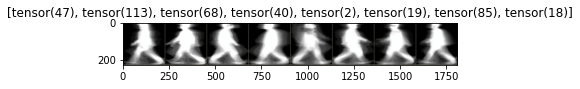

In [8]:

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
# model_conv = torchvision.models.resnet18(pretrained=True)

# for param in model_conv.parameters():
#     param.requires_grad = False
    
# # Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, num_classes)

# device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# model_conv = model_conv.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that only parameters of final layer are being optimized as
# # opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
# exp_lr_scheduler = None

In [14]:
#last layer only-feature extraction
#10epochs
# model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 3.7385 Acc: 0.2507
val Loss: 3.7828 Acc: 0.2225

Epoch 1/4
----------
train Loss: 3.5664 Acc: 0.2949
val Loss: 3.6317 Acc: 0.2601

Epoch 2/4
----------
train Loss: 3.3794 Acc: 0.3619
val Loss: 3.5221 Acc: 0.2708

Epoch 3/4
----------
train Loss: 3.2121 Acc: 0.3847
val Loss: 3.4077 Acc: 0.3271

Epoch 4/4
----------
train Loss: 3.0545 Acc: 0.4430
val Loss: 3.2919 Acc: 0.3566

Training complete in 1m 18s
Best val Acc: 0.356568


In [14]:
#complete training
model_conv = torchvision.models.resnet18(pretrained=True)

# # Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)

for param in model_conv.parameters():
    param.requires_grad = True
    
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

#all params
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=15, gamma=0.1)
# exp_lr_scheduler = None

In [15]:
#20
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 4.6977 Acc: 0.0523
val Loss: 4.1033 Acc: 0.1421

Epoch 1/49
----------
train Loss: 3.5398 Acc: 0.2440
val Loss: 2.6970 Acc: 0.4531

Epoch 2/49
----------
train Loss: 2.4191 Acc: 0.5349
val Loss: 1.7339 Acc: 0.7265

Epoch 3/49
----------
train Loss: 1.5140 Acc: 0.7956
val Loss: 1.0482 Acc: 0.8445

Epoch 4/49
----------
train Loss: 0.9321 Acc: 0.9122
val Loss: 0.5924 Acc: 0.9330

Epoch 5/49
----------
train Loss: 0.5742 Acc: 0.9678
val Loss: 0.3835 Acc: 0.9651

Epoch 6/49
----------
train Loss: 0.3559 Acc: 0.9906
val Loss: 0.2885 Acc: 0.9705

Epoch 7/49
----------
train Loss: 0.2312 Acc: 0.9940
val Loss: 0.2432 Acc: 0.9598

Epoch 8/49
----------
train Loss: 0.1684 Acc: 0.9973
val Loss: 0.1716 Acc: 0.9732

Epoch 9/49
----------
train Loss: 0.1262 Acc: 0.9987
val Loss: 0.1568 Acc: 0.9812

Epoch 10/49
----------
train Loss: 0.1026 Acc: 0.9980
val Loss: 0.1445 Acc: 0.9759

Epoch 11/49
----------
train Loss: 0.0842 Acc: 1.0000
val Loss: 0.1163 Acc: 0.9920

Ep

In [ ]:
optimizer_conv

In [22]:
PATH = "/home/nirbhay/tharun/casia_b/rs18_nm14_ft.pth"
torch.save(model_conv.state_dict(),PATH)
model_conv = model_conv.load_state_dict(torch.load(PATH))